In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
# Generate synthetic data
def generate_sequences(seed):
    torch.manual_seed(seed)
    points = torch.randn(100, 4, 2)  
    directions = torch.randint(0, 2, (100,))
    return points, directions

In [5]:
train_points, train_directions = generate_sequences(seed=19)
test_points, test_directions = generate_sequences(seed=42)

In [6]:
# Prepare data loaders
train_data = TensorDataset(torch.as_tensor(train_points).float(), torch.as_tensor(train_directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(), torch.as_tensor(test_directions).view(-1, 1).float())

In [7]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [9]:
# Define the model using a bidirectional RNN
class SquareModel(nn.Module):
    
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        
        # Bidirectional RNN
        self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, bidirectional=True, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim * 2, self.n_outputs)  # * 2 for bidirectional
    
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H * 2) because it's bidirectional
        batch_first_output, _ = self.basic_rnn(X)
        
        # Only last item in sequence (N, 1, H * 2)
        last_output = batch_first_output[:,-1,:]
        
        # Classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # Final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [10]:
# Model instance
torch.manual_seed(21)
model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)

In [11]:
# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [17]:
# Training the model
def train(model, train_loader, loss_fn, optimizer):
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted==labels).sum().item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    return avg_train_loss, train_accuracy 

In [18]:
# Function to evaluate the model
def evaluate(model, test_loader, loss_fn):
    model.eval()
    epoch_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            epoch_val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    avg_val_loss = epoch_val_loss / len(test_loader)
    val_accuracy = correct_val / total_val
    return avg_val_loss, val_accuracy

In [19]:
# Initialize lists to hold the metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and evaluation loop
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, loss_fn, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, loss_fn)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}')


Epoch 1, Train Loss: 0.6688607845987592, Val Loss: 0.6959213529314313, Train Acc: 0.58, Val Acc: 0.56
Epoch 2, Train Loss: 0.6520241328648159, Val Loss: 0.6925432171140399, Train Acc: 0.59, Val Acc: 0.56
Epoch 3, Train Loss: 0.6682843906538827, Val Loss: 0.6943866099630084, Train Acc: 0.59, Val Acc: 0.56
Epoch 4, Train Loss: 0.668626742703574, Val Loss: 0.6956924625805446, Train Acc: 0.59, Val Acc: 0.57
Epoch 5, Train Loss: 0.6701087185314724, Val Loss: 0.7014718992369515, Train Acc: 0.6, Val Acc: 0.56
Epoch 6, Train Loss: 0.6718256218092782, Val Loss: 0.7036017094339643, Train Acc: 0.59, Val Acc: 0.56
Epoch 7, Train Loss: 0.6509922317096165, Val Loss: 0.699528089591435, Train Acc: 0.57, Val Acc: 0.56
Epoch 8, Train Loss: 0.6741393463952201, Val Loss: 0.7044509138379779, Train Acc: 0.58, Val Acc: 0.54
Epoch 9, Train Loss: 0.6675893664360046, Val Loss: 0.7038381951195853, Train Acc: 0.59, Val Acc: 0.54
Epoch 10, Train Loss: 0.6535439746720451, Val Loss: 0.7017607603754316, Train Acc: 0.

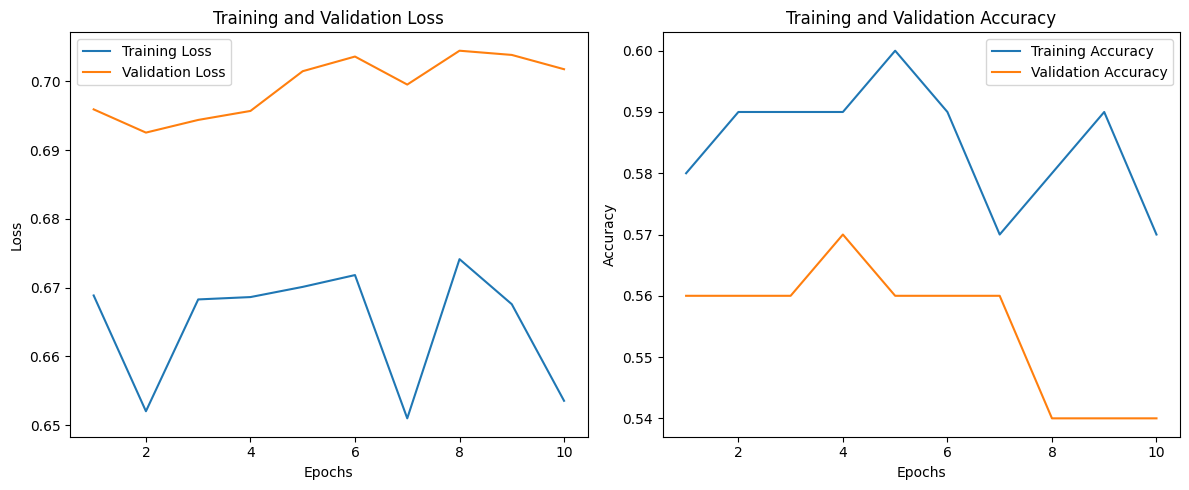

In [22]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Prediction function
def predict(model, input_sequence):
    model.eval()
    with torch.no_grad():
        output = model(input_sequence)
        prediction = (torch.sigmoid(output) > 0.5).float()
    return prediction

In [24]:
sample_sequence = torch.tensor([[[0.1, 0.2], [0.2, 0.1], [0.3, 0.4], [0.4, 0.3]]], dtype=torch.float32)
predicted_label = predict(model, sample_sequence)
print(f'Predicted Label: {predicted_label.item()}')

Predicted Label: 0.0
